In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option("display.max_colwidth", 200)

In [2]:
df = pd.read_csv('Combined_News_DJIA.csv')

In [32]:
# df.tail()
df.shape

(1989, 27)

In [5]:
#fix nans
documents = []
for row in range(df.shape[0]):
    for col in range(2,27):
        if type(df.iloc[row,col])!=str:
            print(df.iloc[row,col])
            documents.append(" ")
        else:
            documents.append(df.iloc[row,col])
len(documents)

nan
nan
nan
nan
nan
nan
nan


49725

In [6]:
news_df = pd.DataFrame({'document':documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")


# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [7]:
news_df[0:5]

,document,clean_doc
0,"b""Georgia 'downs two Russian warplanes' as countries move to brink of war""",georgia downs russian warplanes countries move brink
1,b'BREAKING: Musharraf to be impeached.',breaking musharraf impeached
2,b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)',russia today columns troops roll into south ossetia footage from fighting youtube
3,"b'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire'",russian tanks moving towards capital south ossetia which reportedly been completely destroyed georgian artillery fire
4,"b""Afghan children raped with 'impunity,' U.N. official says - this is sick, a three year old was raped and they do nothing""",afghan children raped with impunity official says this sick three year raped they nothing


In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dkout\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # check shape of the document-term matrix

(49725, 1000)

In [12]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

10

In [13]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    print(terms_comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
china
 
israel
 
says
 
world
 
russia
 
korea
 
north
 
Topic 1: 
korea
 
china
 
north
 
south
 
korean
 
japan
 
nuclear
 
Topic 2: 
korea
 
north
 
israel
 
south
 
gaza
 
korean
 
nuclear
 
Topic 3: 
china
 
israel
 
gaza
 
palestinian
 
hamas
 
palestinians
 
israeli
 
Topic 4: 
russia
 
says
 
ukraine
 
china
 
israel
 
iran
 
putin
 
Topic 5: 
world
 
russia
 
israel
 
news
 
iran
 
bank
 
largest
 
Topic 6: 
says
 
iran
 
minister
 
nuclear
 
report
 
prime
 
government
 
Topic 7: 
iran
 
nuclear
 
attack
 
saudi
 
death
 
iranian
 
years
 
Topic 8: 
police
 
says
 
world
 
protesters
 
iran
 
israel
 
russia
 
Topic 9: 
government
 
police
 
president
 
chinese
 
israel
 
internet
 
minister
 


In [14]:
#Get params and see which topics are high for specific articles, 
comps = svd_model.components_

n,d = X.shape #Featurized articles
topic_scores = np.hstack([comps@X[i:i+1,:].T for i in range(n)])
topic_scores.shape

(10, 49725)

In [15]:
#Now let's average out those scores over the surrounding 1000 articles scores to see how average scores change over time
d,n = topic_scores.shape
averages = []
i=0
start = 2008
end = 2016
dates = []
while(i<n):
    running_sum = topic_scores[:,i:i+1]
    i+=1
    count = 0
    while (i)%1000 != 0:
        running_sum = running_sum + topic_scores[:,i:i+1]
        i+=1
        count+=1
    averages.append(running_sum/count)
    dates.append(start + (end-start)*i/n)
    

In [16]:
averages = np.hstack(average for average in averages)
averages.shape

(10, 49)

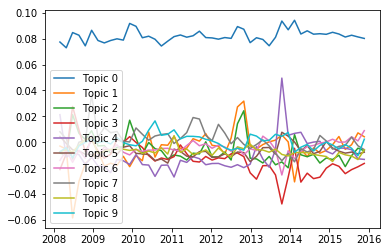

In [17]:
import matplotlib.pyplot as plt
plt.plot(dates[:-1],averages.T)
plt.legend(["Topic "+str(i) for i in range(averages.shape[0])])

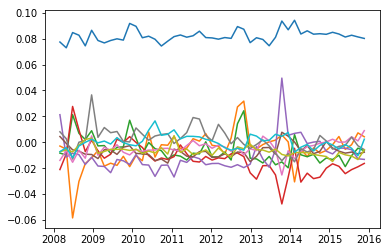

In [18]:
plt.plot(dates[:-1],averages.T)

In [77]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
lda = LatentDirichletAllocation(n_components=5, random_state=0, doc_topic_prior=0.001, topic_word_prior=0.01)

In [78]:
lda.fit(X) 

LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.001,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=0.01,
             total_samples=1000000.0, verbose=0)

In [79]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(lda.components_):
    terms_comp = zip(terms, comp)
#     print(terms_comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ", end='')
    for t in sorted_terms:
        print(t[0], end = '')
        print(" ", end='')
    print()

Topic 0: world china japan million year years water 
Topic 1: government china court internet snowden people chinese 
Topic 2: police killed pakistan isis dead attack iraq 
Topic 3: russia russian iran ukraine putin says world 
Topic 4: israel israeli korea gaza north palestinian saudi 


In [80]:
#Get params and see which topics are high for specific articles, 
comps = lda.components_

n,d = X.shape #Featurized articles
topic_scores = np.hstack([comps@X[i:i+1,:].T for i in range(n)])
topic_scores.shape

(5, 49725)

In [81]:
#Now let's average out those scores over the surrounding 1000 articles scores to see how average scores change over time
d,n = topic_scores.shape
averages = []
i=0
start = 2008
end = 2016
dates = []
while(i<n):
    running_sum = topic_scores[:,i:i+1]
    i+=1
    count = 0
    while (i)%1000 != 0:
        running_sum = running_sum + topic_scores[:,i:i+1]
        i+=1
        count+=1
    averages.append(running_sum/count)
    dates.append(start + (end-start)*i/n)

In [82]:
averages = np.hstack(average for average in averages)
averages.shape

(5, 49)

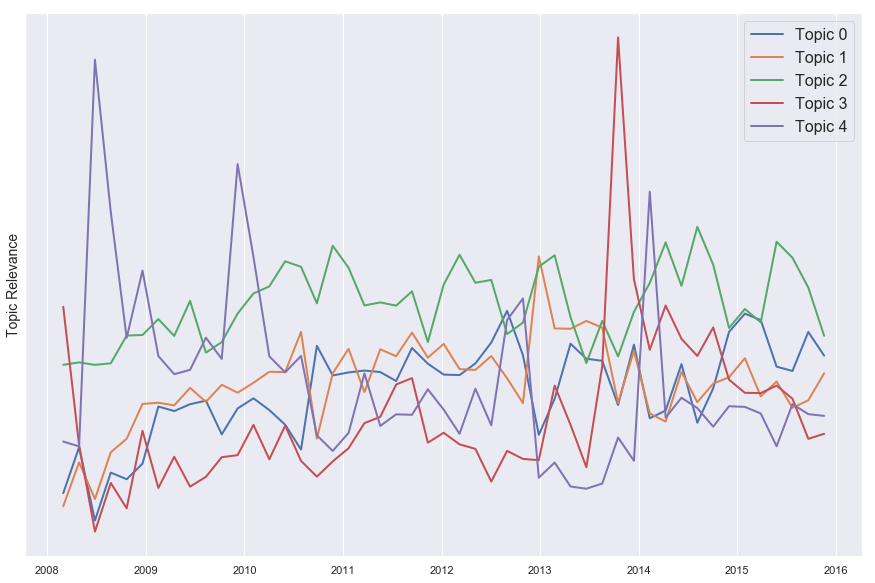

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.plot(dates[:-1],averages.T[:,:5], linewidth = 2)
plt.ylabel("Topic Relevance", fontsize = 14)
plt.yticks([])
plt.legend(["Topic "+str(i) for i in range(averages.shape[0])], fontsize = 16)